In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [2]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm

In [3]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [25]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [8]:
sample = "Sample_N705_-_ER1"
new_sample_name = "MCF7-labo-er1"
quant_params = "raw-reads/pc-decoys-k17-1.4.0/forceCells-3000-noWh-mappings"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp779"
cell_line="MCF7"
cond = "er1"

In [637]:
sample = "er1"
new_sample_name = "MCF7-labo-er1"
quant_params = "trimmed-reads-cutadapt/all-decoys-k17/forceCells-3000/raw"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "old/dsp779"
cell_line="MCF7"
cond = "er1"

### Plotting parameters

In [5]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

### Raw CB frequency

In [10]:
y = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/raw_cb_frequency.txt", header=None)[1]

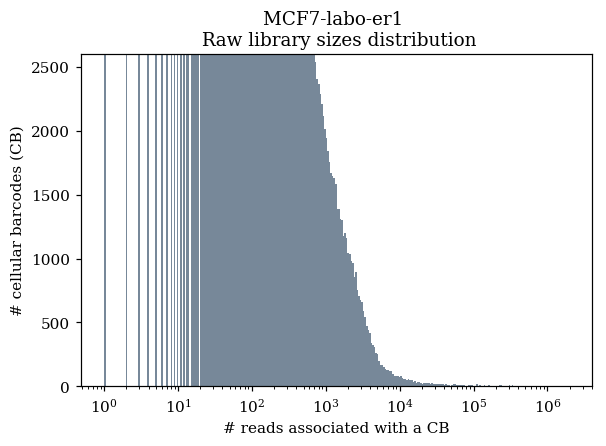

In [14]:
plt.title(f"{new_sample_name} \n Raw library sizes distribution")
plt.ylim(0,2600);
plt.xlabel("# reads associated with a CB")
plt.ylabel("# cellular barcodes (CB)")
rnaseq.plotting.loghist(y, bins=300, color = "lightslategray")

In [16]:
x = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/featureDump.txt")

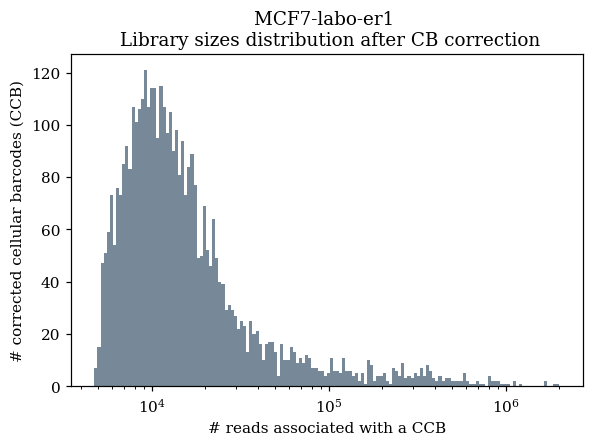

In [17]:
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction")
plt.xlabel("# reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plotting.loghist(x["CorrectedReads"], bins=150, color = "lightslategray")

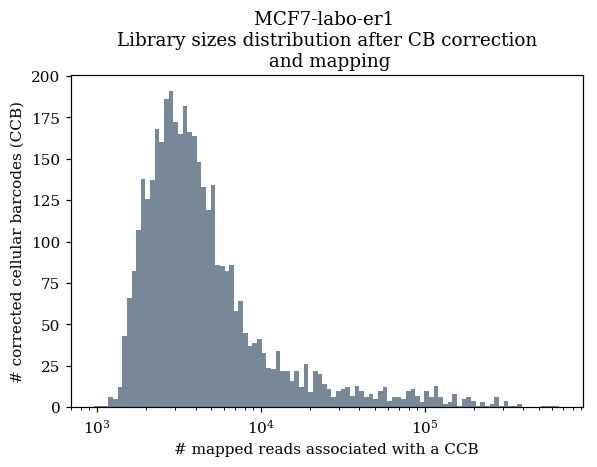

In [18]:
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction \n and mapping")
plt.xlabel("# mapped reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plotting.loghist(x["MappedReads"], bins=100, color = "lightslategray")

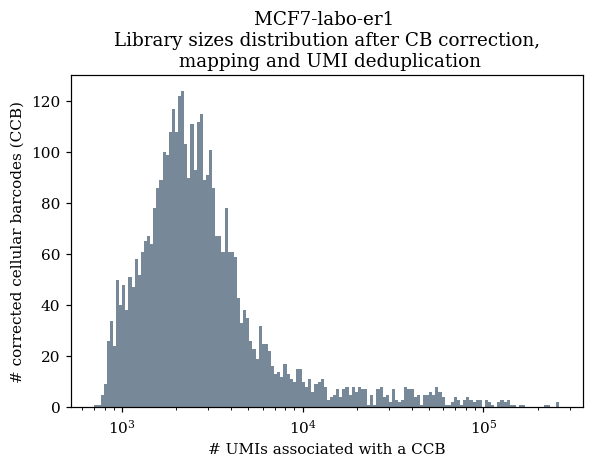

In [22]:
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plotting.loghist(x["DeduplicatedReads"], bins=150, color = "lightslategray")

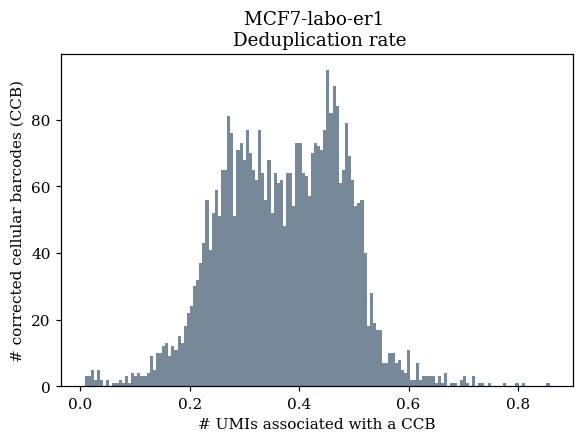

In [21]:
plt.title(f"{new_sample_name} \n Deduplication rate")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
plt.hist(x["DedupRate"], bins=150, color = "lightslategray");

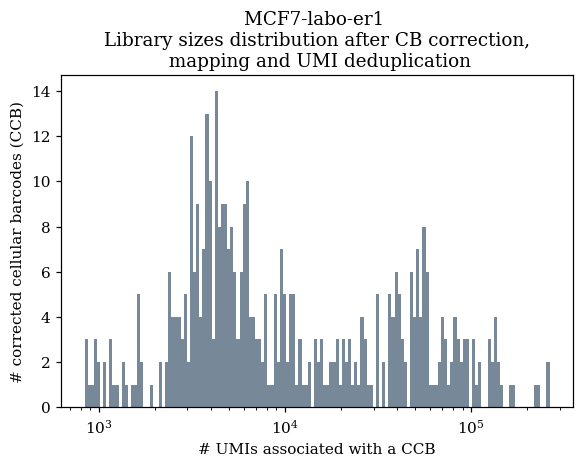

In [20]:
i = x["DedupRate"]<0.5
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plotting.loghist(x["DeduplicatedReads"][~i], bins=150, color = "lightslategray")

### Loading raw count matrix

In [34]:
X = rnaseq.readwrite.read_mtx("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/old/dsp779/quant/star_solo/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/Dedup_1MM_Directional_UMItools/er1/Solo.out/Gene/raw/matrix.mtx")

obs = pd.read_table("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/old/dsp779/quant/star_solo/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/Dedup_1MM_Directional_UMItools/er1/Solo.out/Gene/raw/barcodes.tsv", header=None)[0].values
var = pd.read_table("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/old/dsp779/quant/star_solo/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/Dedup_1MM_Directional_UMItools/er1/Solo.out/Gene/raw/features.tsv", header=None)[0].values


sc = anndata.AnnData(X.T, obs = pd.DataFrame(index = obs), var = pd.DataFrame(index = var))

del X, obs, var

rnaseq.setup.setup_anndata(sc,  cdna = "3' tag", exp = "sc")
rnaseq.pp.filter_genes(sc)

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [36]:
rnaseq.setup.annotate_samples(sc, samples_annot_name = "conditions", samples_annot = cond)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "cell_lines", samples_annot = cell_line)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "source", samples_annot = "labo")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "samples", samples_annot = new_sample_name, ow = True)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.pp.filter_cells(sc, n_counts_min = 1)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr", ow = True)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac", ow = True)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac", ow = True)

conditions already annotated. Set ow = True if you want to overwrite.
cell_lines already annotated. Set ow = True if you want to overwrite.
source already annotated. Set ow = True if you want to overwrite.
Annotating samples...
total_UMIs already annotated. Set ow = True if you want to overwrite.
#_genes already annotated. Set ow = True if you want to overwrite.
Annotating max_corr...
Normalization by total UMIs...


/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/pp.py:163: RuntimeWarning: invalid value encountered in true_divide
  x = (x.T / x.sum(1)).T * tot


Log2 + 1 tranformation...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/setup.py:107: RuntimeWarning: invalid value encountered in true_divide
  x = x.sum(1) / adata.X.toarray().sum(1)


Annotating rp_frac...
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


21

In [33]:
sc.obs

conditions cell_lines source        samples   mt_frac   rp_frac  \
AAAAACAACCGT        er1       MCF7   labo  MCF7-labo-er1  0.000000  0.185520   
AAAAAGAGTCAA        er1       MCF7   labo  MCF7-labo-er1  0.135593  0.101695   
AAAAAGGTCATC        er1       MCF7   labo  MCF7-labo-er1  0.095238  0.071429   
AAAACATCACCT        er1       MCF7   labo  MCF7-labo-er1  0.066667  0.040000   
AAAACCACGGTA        er1       MCF7   labo  MCF7-labo-er1  0.121951  0.073171   
...                 ...        ...    ...            ...       ...       ...   
TTTTACCAGAGG        er1       MCF7   labo  MCF7-labo-er1  0.166667  0.166667   
TTTTGGAAGCGC        er1       MCF7   labo  MCF7-labo-er1  0.010283  0.151671   
TTTTGGAGAGCA        er1       MCF7   labo  MCF7-labo-er1  0.020478  0.123549   
TTTTTGCAAACA        er1       MCF7   labo  MCF7-labo-er1  0.005355  0.160643   
TTTTTTTTTTTT        er1       MCF7   labo  MCF7-labo-er1  0.019060  0.096569   

              max_corr  total_UMIs  #_genes  keep  
AAAAACAACCGT       NaN       221.0      193  True  
AAAAAGAGTCAA       NaN        59.0       53  True  
AAAAAGGTCATC       NaN        42.0       37  True  
AAAACATCACCT       NaN        75.0       68  True  
AAAACCACGGTA       NaN        41.0       36  True  
...                ...         ...      ...   ...  
TTTTACCAGAGG       NaN        60.0       51  True  
TTTTGGAAGCGC       NaN      1167.0      805  True  
TTTTGGAGAGCA       NaN      1465.0      966  True  
TTTTTGCAAACA       NaN       747.0      564  True  
TTTTTTTTTTTT       NaN       787.0      610  True  

[7945 rows x 10 columns]

In [807]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")

rnaseq.setup.annotate_samples(sc, samples_annot_name = "conditions", samples_annot = cond)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "cell_lines", samples_annot = cell_line)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "source", samples_annot = "labo")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "samples", samples_annot = new_sample_name, ow = True)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac")

sc.obs_names = sc.obs["CB"]

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating conditions...
Annotating cell_lines...
Annotating source...
Annotating samples...
Annotating total_UMIs...
Annotating #_genes...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating rp_frac...
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


In [808]:
sc.X.shape

(3999, 20305)

In [801]:
x = pd.read_csv("./trimmed_tot_umis.csv", index_col=0)
cb = np.intersect1d(x.index, sc.obs_names)
x = x.loc[cb]
sc._inplace_subset_obs(cb)
sc.obs["trimming-rate"] = x["total_UMIs"] / sc.obs["total_UMIs"]

(1720,)

In [743]:
decoys = pd.read_csv("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/pc-decoys-k17-1.4.0/forceCells-3000-noWh-mappings/Sample_N705_-_ER1/logs/counts-decoys.txt", header = None)


vals = [int(decoys.loc[i].values[0][:-12]) for i in range(len(decoys))]
index = [decoys.loc[i].values[0][-12:] for i in range(len(decoys))]
decoys = pd.DataFrame(vals, index = index)

cb = np.intersect1d(decoys.index, sc.obs["CB"])
sc._inplace_subset_obs(cb)
decoys = decoys.reindex(cb)
sc.obs["decoys"] = decoys

del decoys, vals, index, cb

In [757]:
lengths = pd.read_csv("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/pc-decoys-k17-1.4.0/forceCells-3000-noWh-mappings/Sample_N705_-_ER1/logs/lengths-decoys.txt", header = None, delimiter=" ", index_col=0)

cb = np.intersect1d(lengths.index, sc.obs["CB"])
sc._inplace_subset_obs(cb)
lengths = lengths.reindex(cb)
sc.obs["len-decoys"] = lengths

del lengths, cb

sc.obs["mean_len_decoys"] = sc.obs["len-decoys"] / sc.obs["decoys"]

In [746]:
targets = pd.read_csv("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/pc-decoys-k17-1.4.0/forceCells-3000-noWh-mappings/Sample_N705_-_ER1/logs/counts-targets.txt", header = None)


vals = [int(targets.loc[i].values[0][:-12]) for i in range(len(targets))]
index = [targets.loc[i].values[0][-12:] for i in range(len(targets))]
targets = pd.DataFrame(vals, index = index)

cb = np.intersect1d(targets.index, sc.obs["CB"])
sc._inplace_subset_obs(cb)
targets = targets.reindex(cb)
sc.obs["targets"] = targets

del targets, vals, index, cb

In [758]:
lengths = pd.read_csv("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/pc-decoys-k17-1.4.0/forceCells-3000-noWh-mappings/Sample_N705_-_ER1/logs/lengths-targets.txt", header = None, delimiter=" ", index_col=0)

cb = np.intersect1d(lengths.index, sc.obs["CB"])
sc._inplace_subset_obs(cb)
lengths = lengths.reindex(cb)
sc.obs["len-targets"] = lengths

del lengths, cb

sc.obs["mean_len_targets"] = sc.obs["len-targets"] / sc.obs["targets"]

In [782]:
sc.obs["decoys-rate"] = sc.obs["decoys"] / (sc.obs["decoys"] + sc.obs["targets"])

In [776]:
adapter = "CTGTCTCTTATACACATCTC"

from difflib import SequenceMatcher

In [779]:
sc.obs["adapter-in-cb"] = [str(SequenceMatcher(None, adapter, cb).ratio() > 0.6) for cb in sc.obs_names]

In [636]:
ps = rnaseq.utils.pseudobulk(sc)
rnaseq.pp.log_norm(ps)

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Normalization by total UMIs...
Log2 + 1 tranformation...


In [639]:
ps_trimmed = rnaseq.utils.pseudobulk(sc)
rnaseq.pp.log_norm(ps_trimmed)

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Normalization by total UMIs...
Log2 + 1 tranformation...


In [652]:
m = pd.read_table("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/bulk/bulk-MCF7_DSP356/quant/star/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/E/E-1/rsem.genes.results")
genes = np.array([g.split(".")[0] for g in m["gene_id"]])
bulk_star = anndata.AnnData(X = np.log2(m["TPM"].values + 1).reshape(1,-1), var = {"ensembl_gene_id" : genes})
rnaseq.setup.setup_anndata(bulk_star, cdna = "full length")

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [655]:
rnaseq.utils.match_genes([ps, ps_trimmed, bulk_star])

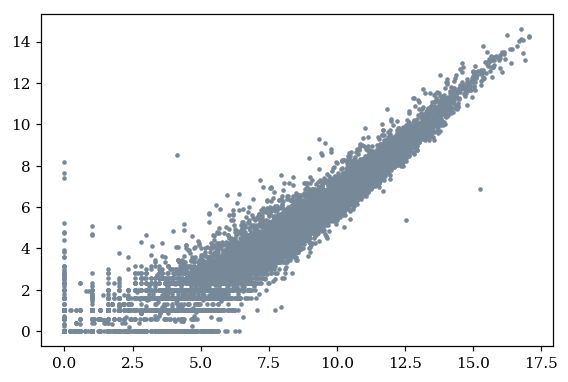

In [648]:
rnaseq.plotting.scatter(ps.X.toarray(), ps_trimmed.X.toarray(), s=4)

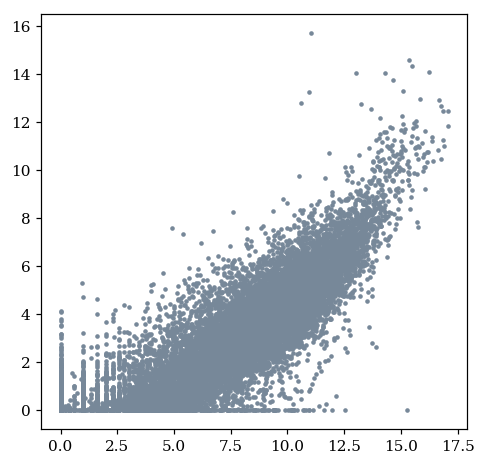

In [658]:
plt.subplots(figsize=(5,5))
rnaseq.plotting.scatter(ps.X.toarray(), bulk_star.X.toarray(), s=4)

In [660]:
stats.pearsonr(ps.X.toarray().ravel(), bulk_star.X.toarray().ravel())

(0.8941633206765617, 0.0)

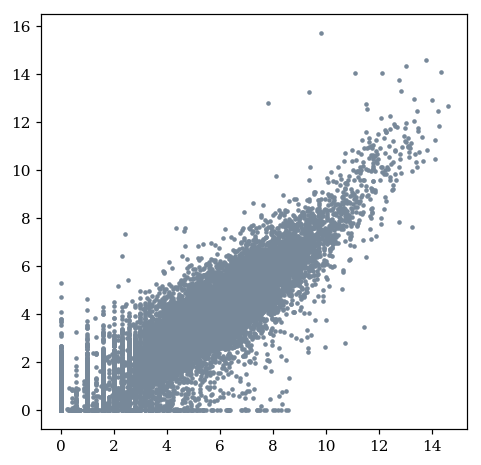

In [657]:
plt.subplots(figsize=(5,5))
rnaseq.plotting.scatter(ps_trimmed.X.toarray(), bulk_star.X.toarray(), s=4)

In [661]:
stats.pearsonr(ps_trimmed.X.toarray().ravel(), bulk_star.X.toarray().ravel())

(0.9299191695393836, 0.0)

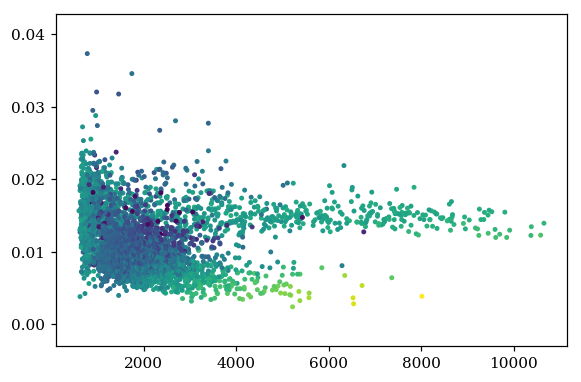

In [601]:
# from vpolo.alevin import parser

# tier = parser.read_quants_bin("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/pc-decoys-k17-1.4.0/forceCells-3000-noWh/Sample_N705_-_ER1/", mtype="tier")
# sc.obs["tier"] = (tier == 3).sum(1).values/(tier == 1).sum(1).values
plt.scatter(sc.obs["#_genes"], sc.obs["mt_frac"], s=5, c=sc.obs["DedupRate"])

### 1st filtering

#### QC before filtering

##### Umap

In [ ]:
rnaseq.pp.log_norm(sc, plot=True, inplace=True, ow = True)
scanpy.pp.pca(sc)
scanpy.pl.pca_variance_ratio(sc)

In [ ]:
scanpy.pp.neighbors(sc, n_pcs = 15, n_neighbors = 15)
scanpy.tl.umap(sc)

In [678]:
rnaseq.plotting.loghist(sc.obs["decoys"], bins = 100);

In [773]:
rnaseq.plotting.loghist(sc.obs["len-decoys"], bins = 100);

In [774]:
rnaseq.plotting.loghist(sc.obs["len-targets"], bins = 100);

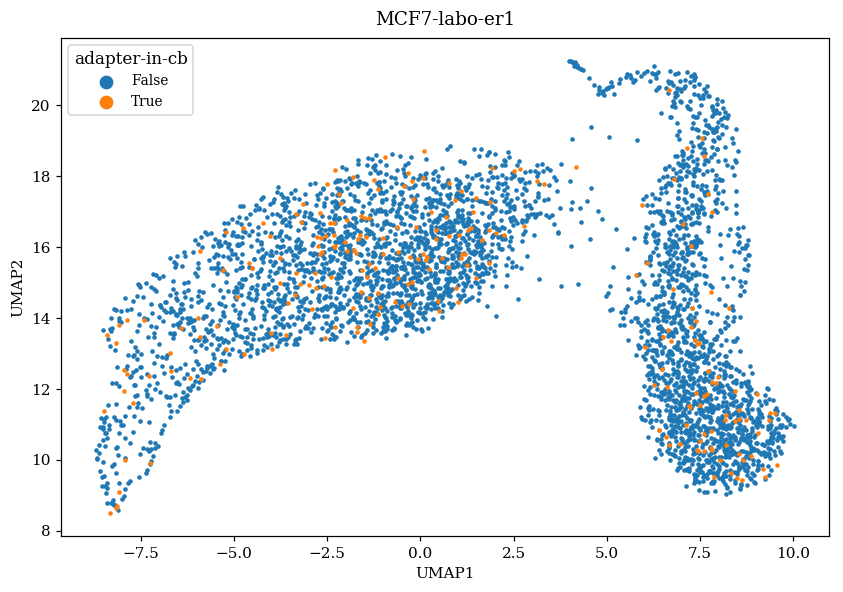

In [781]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["adapter-in-cb"], \
    s = 4, palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "adapter-in-cb", title = new_sample_name)

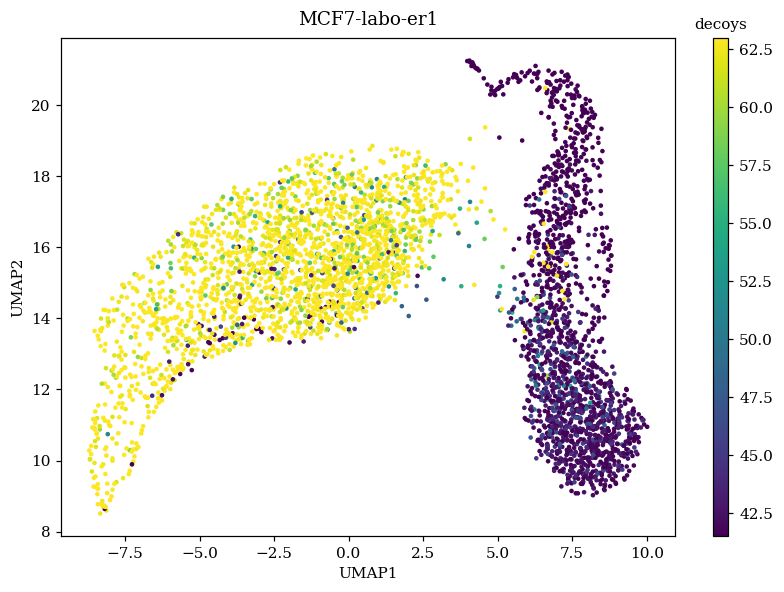

In [759]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["mean_len_decoys"], \
    s = 4, palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "decoys", title = new_sample_name)

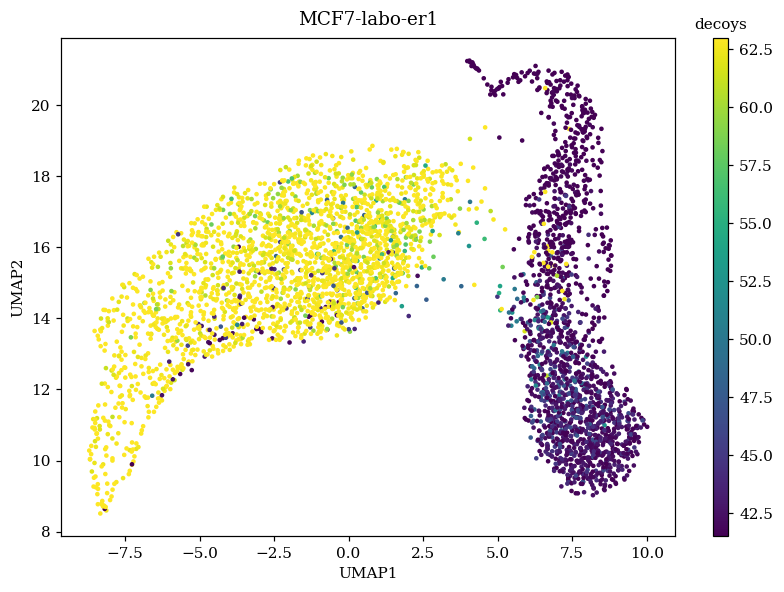

In [772]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["mean_len_targets"], \
    s = 4, palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "decoys", title = new_sample_name)

In [ ]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["decoys"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "decoys", title = new_sample_name)

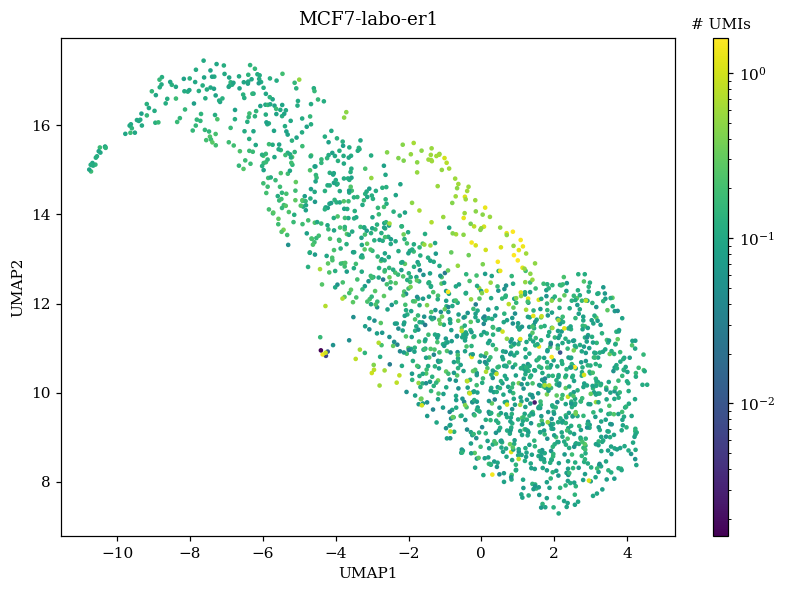

In [805]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["trimming-rate"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "# UMIs", title = new_sample_name)

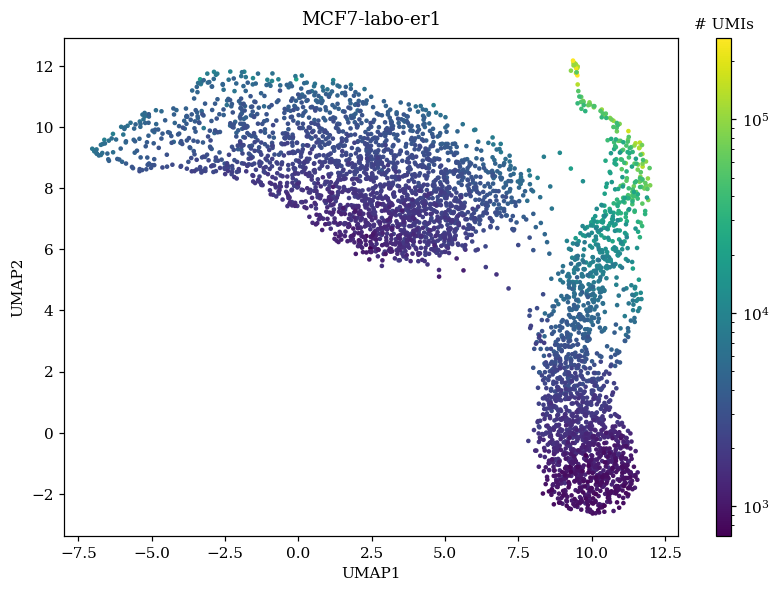

In [812]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["total_UMIs"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "# UMIs", title = new_sample_name)

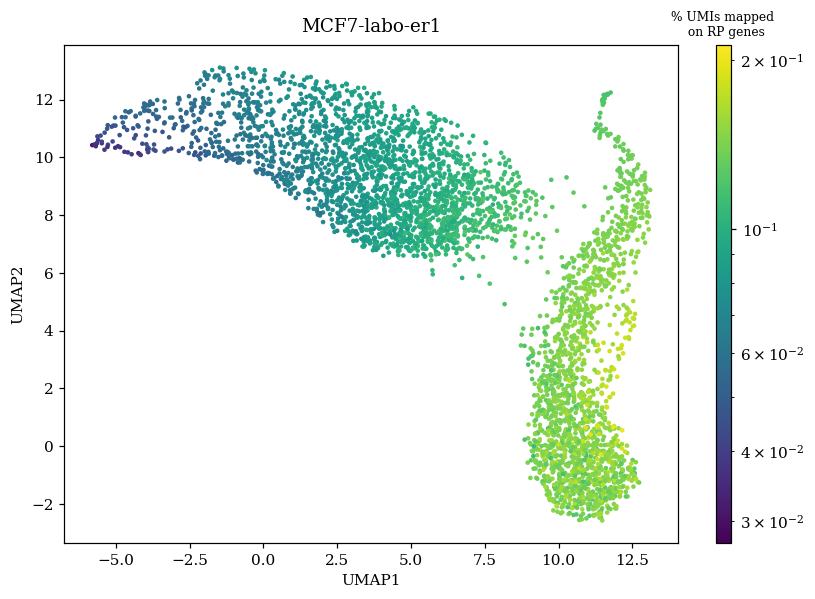

In [605]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["rp_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on RP genes", title = new_sample_name)

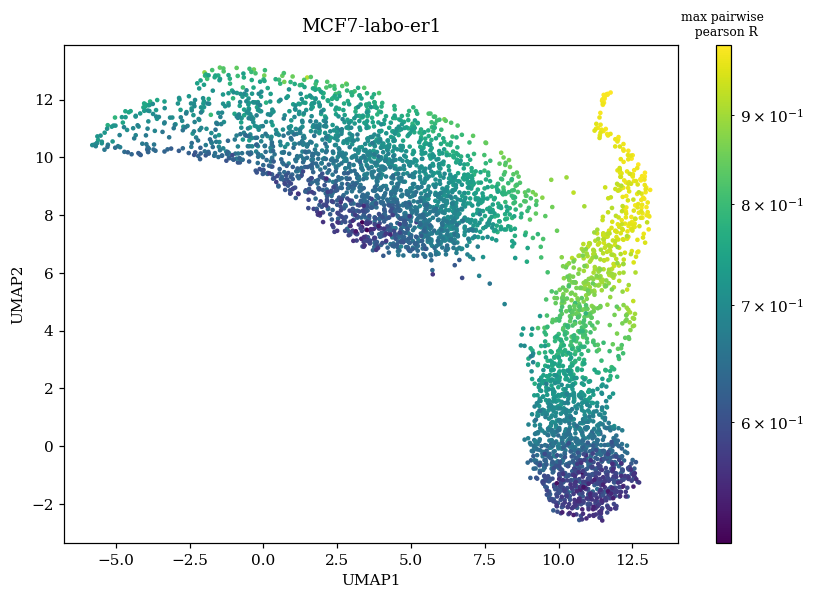

In [607]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

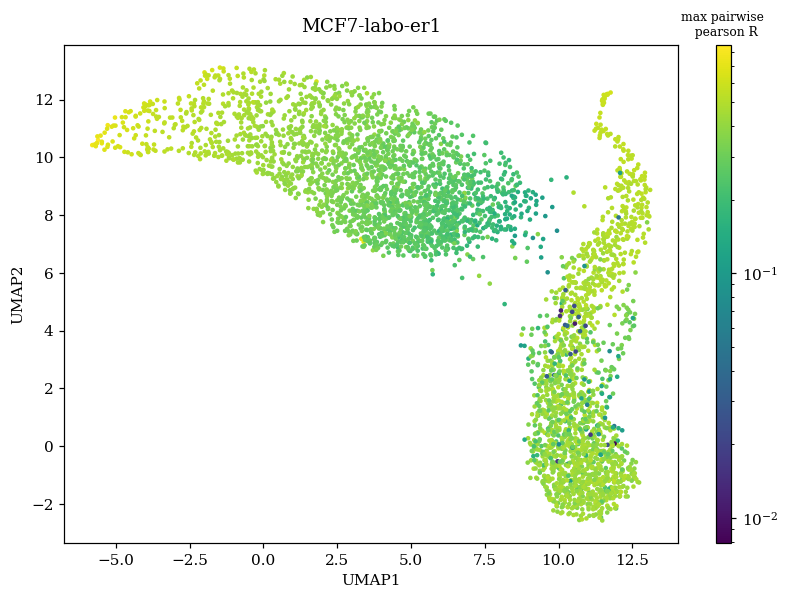

In [608]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["DedupRate"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

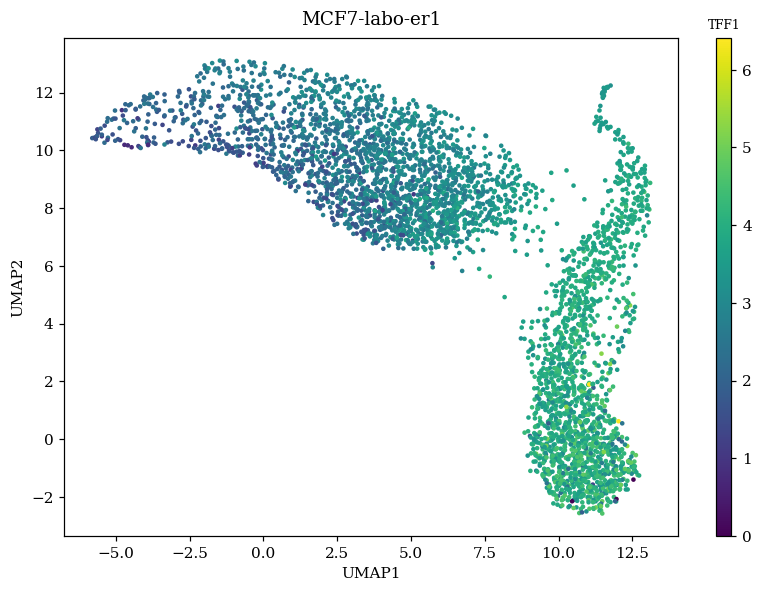

In [629]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.X.toarray()[:, sc.var["external_gene_name"] == "TFF1"].ravel(), \
    s = 4, xlabel="UMAP1", ylabel="UMAP2", color_title = "TFF1", title = new_sample_name)

##### QC metrics distibutions

/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/plotting.py:57: RuntimeWarning: divide by zero encountered in log10
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/numpy/core/function_base.py:154: RuntimeWarning: invalid value encountered in add
  y += start


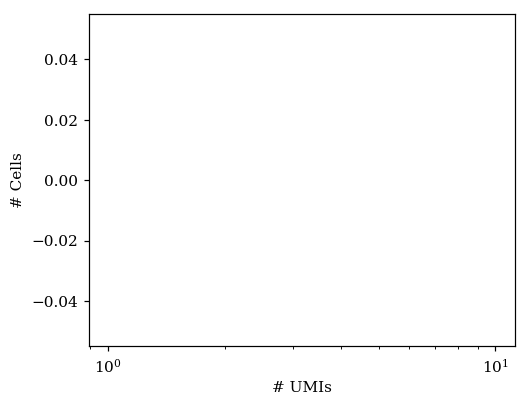

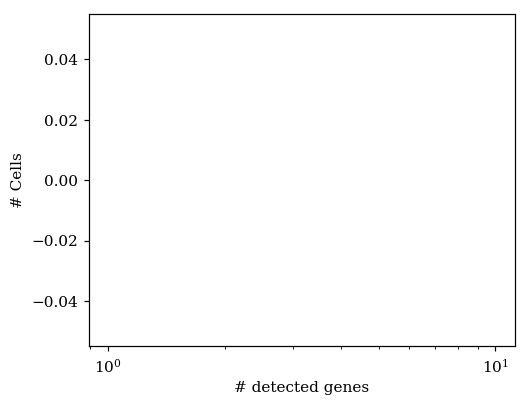

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6575: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6576: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: max must be larger than min in range parameter.

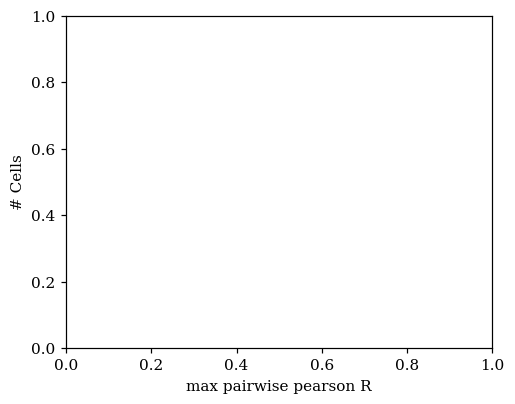

In [21]:
rnaseq.pp.plot_qc(sc,  rp_min = 0.115, n_bins = 150)

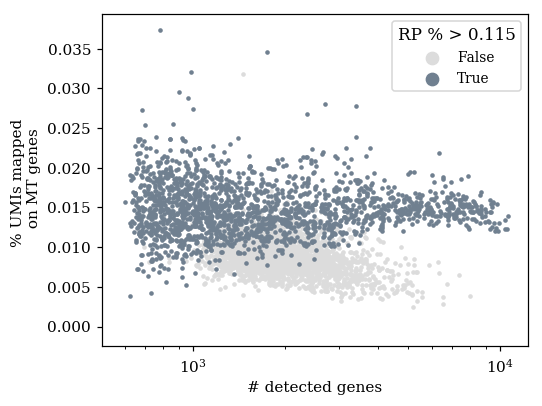

In [632]:
plt.subplots(figsize=(5,4))
rnaseq.plotting.scatter(sc.obs["#_genes"], sc.obs["mt_frac"], color = sc.obs["keep"], \
    xlabel = "# detected genes", ylabel = "% UMIs mapped \n on MT genes", color_title = "RP % > 0.115", norm = LogNorm(), s = 4, palette = {"True" : "slategray", "False" : "gainsboro"})
plt.xscale('log')
plt.show()

#### Test some thresholds

##### Umap

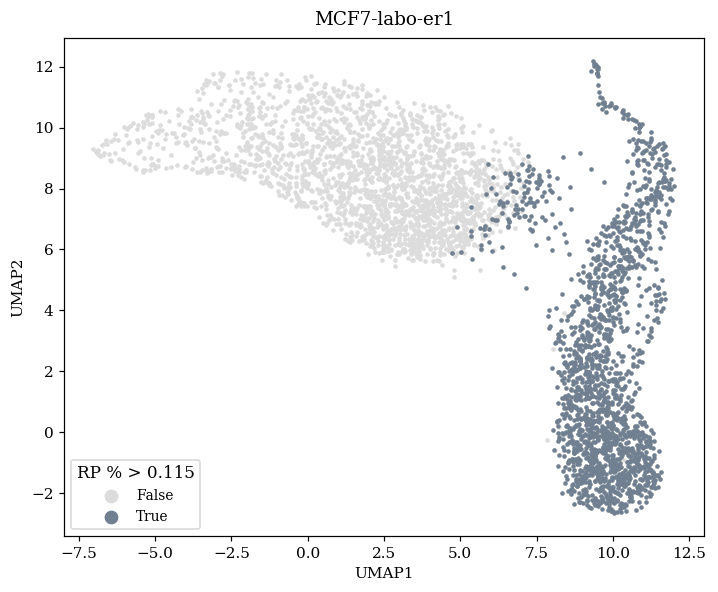

In [813]:
rnaseq.pp.filter_cells(sc, rp_min = 0.115, inplace = False)

plt.subplots(figsize = (7.5,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["keep"], \
    s = 4, norm = LogNorm(), xlabel="UMAP1", ylabel="UMAP2", color_title = "RP % > 0.115", \
    title = new_sample_name, palette = {"True" : "slategray", "False" : "gainsboro"})

In [818]:
np.savetxt("./rb-cbs.txt", sc.obs_names[sc.obs["keep"] == "False"], fmt = '%s')

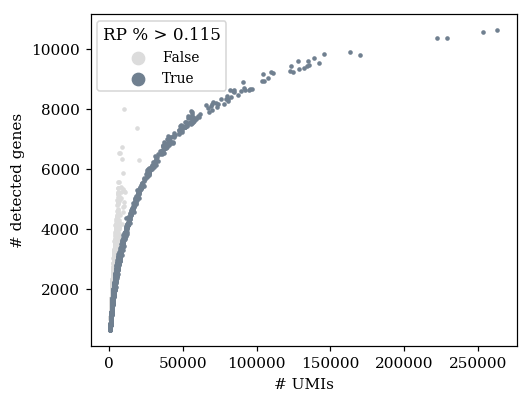

In [627]:
plt.subplots(figsize=(5,4))
rnaseq.plotting.scatter(sc.obs["total_UMIs"], sc.obs["#_genes"], color = sc.obs["keep"], order_color=True, \
s = 4, color_title = "RP % > 0.115", xlabel = "# UMIs", ylabel = "# detected genes", palette = {"True" : "slategray", "False" : "gainsboro"})

Text(0.5, 1.0, 'Log-scale')

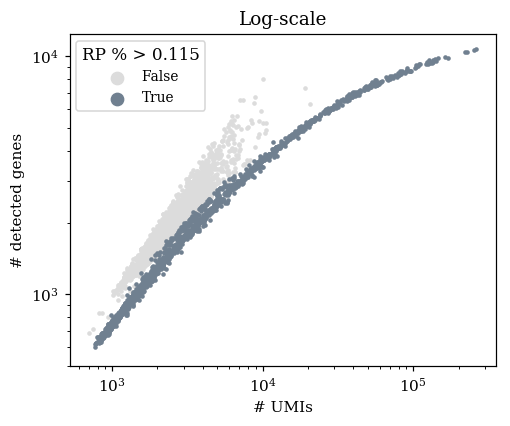

In [628]:
plt.subplots(figsize=(5,4))
rnaseq.plotting.scatter(sc.obs["total_UMIs"], sc.obs["#_genes"], color = sc.obs["keep"], order_color=True, \
s = 4, color_title = "RP % > 0.115", xlabel = "# UMIs", ylabel = "# detected genes", palette = {"True" : "slategray", "False" : "gainsboro"})
plt.xscale("log")
plt.yscale("log")
plt.title("Log-scale")

##### DEA

In [691]:
rnaseq.pp.filter_genes(sc, n_counts=2, n_samples=3)
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="keep", method = "wilcoxon", groups=["False"], reference="True", n_genes=2000, rankby_abs=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [708]:
rnaseq.utils.show_enrichr_libraies()

Genes_Associated_with_NIH_Grants
Cancer_Cell_Line_Encyclopedia
Achilles_fitness_decrease
Achilles_fitness_increase
Aging_Perturbations_from_GEO_down
Aging_Perturbations_from_GEO_up
Allen_Brain_Atlas_10x_scRNA_2021
Allen_Brain_Atlas_down
Allen_Brain_Atlas_up
ARCHS4_Cell-lines
ARCHS4_IDG_Coexp
ARCHS4_Kinases_Coexp
ARCHS4_TFs_Coexp
ARCHS4_Tissues
BioCarta_2013
BioCarta_2015
BioCarta_2016
BioPlanet_2019
BioPlex_2017
CCLE_Proteomics_2020
CellMarker_Augmented_2021
ChEA_2013
ChEA_2015
ChEA_2016
Chromosome_Location
Chromosome_Location_hg19
ClinVar_2019
CORUM
COVID-19_Related_Gene_Sets
COVID-19_Related_Gene_Sets_2021
Data_Acquisition_Method_Most_Popular_Genes
dbGaP
DepMap_WG_CRISPR_Screens_Broad_CellLines_2019
DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
Descartes_Cell_Types_and_Tissue_2021
Disease_Perturbations_from_GEO_down
Disease_Perturbations_from_GEO_up
Disease_Signatures_from_GEO_down_2014
Disease_Signatures_from_GEO_up_2014
DisGeNET
Drug_Perturbations_from_GEO_2014
Drug_Perturbations_

/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = pd.DataFrame(np.array(data[gene_set_library])[:,1:], columns=["Term", "P-value", "Z-score", "Combined Score", "Genes", "Adjusted P-value", "Old P-value", "Old adjusted P-value"])
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous 

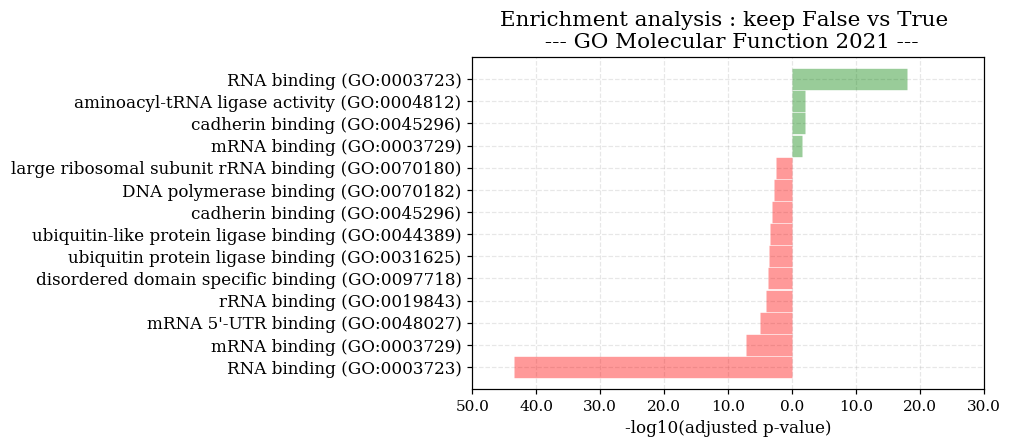

In [709]:
rnaseq.dea.enrichr(sc, group = "False", libraries="GO_Molecular_Function_2021", lfc_cutoff=0.5);

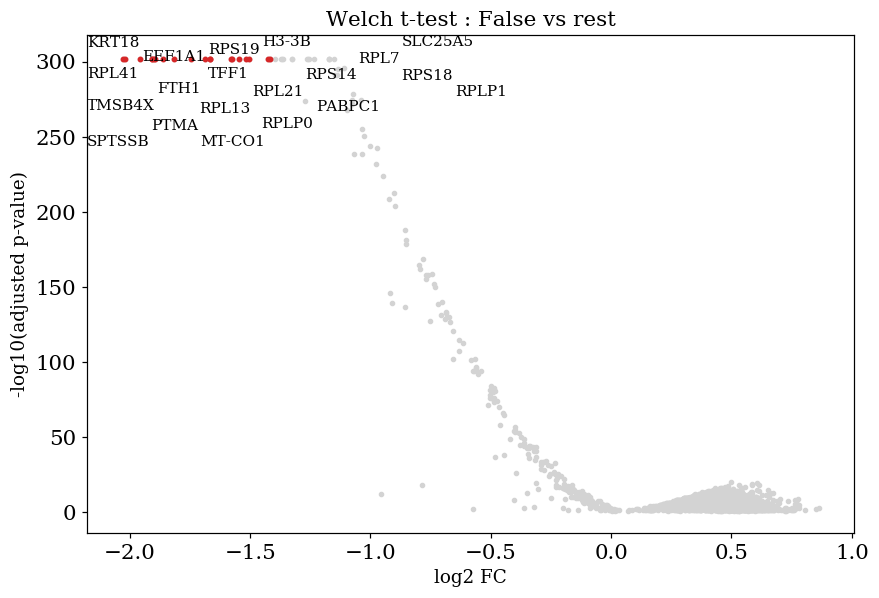

In [702]:
rnaseq.dea.volcano_plot(sc, group="False")

In [696]:
scanpy.get.rank_genes_groups_df(sc, group="False")

scores    names  logfoldchanges     pvals  pvals_adj
0    -52.089127    KRT18       -2.027937  0.000000   0.000000
1    -52.049671   TMSB4X       -2.018173  0.000000   0.000000
2    -51.526669   EEF1A1       -1.906152  0.000000   0.000000
3    -51.250343   SPTSSB       -1.896515  0.000000   0.000000
4    -51.094051    RPS19       -1.898135  0.000000   0.000000
...         ...      ...             ...       ...        ...
1995  -2.078669    HACD3        0.017531  0.037648   0.061659
1996   2.077927    EIF3C        0.069440  0.037716   0.061739
1997  -2.077680     ELOB        0.005302  0.037739   0.061746
1998   2.073861    CNDP2        0.598070  0.038092   0.062293
1999  -2.071511  CSNK1G2        0.412857  0.038311   0.062619

[2000 rows x 5 columns]

#### Filtering cells

In [591]:
rnaseq.pp.filter_cells(sc, rp_min = 0.115, inplace = True)

#### Number of cells after filtering

In [369]:
sc.X.shape

(1843, 20305)

### 2nd filtering

In [ ]:
import doubletdetection

clf = doubletdetection.BoostClassifier()
# raw_counts is a cells by genes count matrix
labels = clf.fit(sc.layers["raw"].toarray()).predict()
# higher means more likely to be doublet
scores = clf.doublet_score()

#### QC before filtering

##### Umap

Normalization by total UMIs...
Log2 + 1 tranformation...


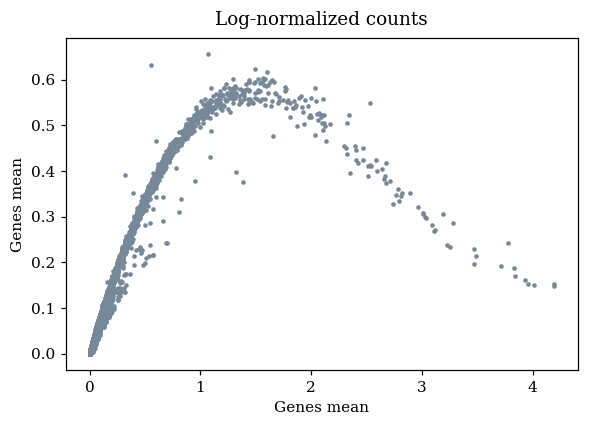

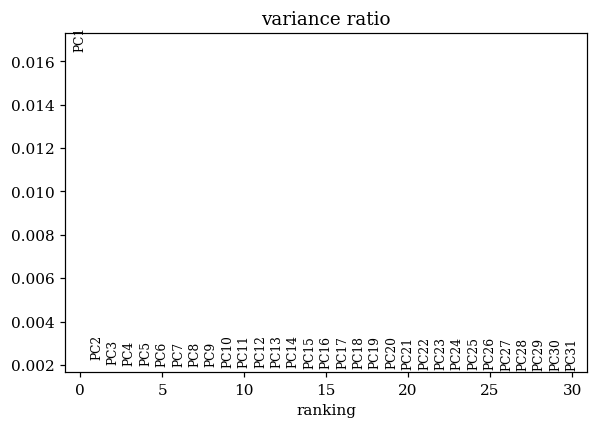

In [592]:
rnaseq.pp.log_norm(sc, plot=True, inplace=True, ow = True)
scanpy.pp.pca(sc)
scanpy.pl.pca_variance_ratio(sc)

In [593]:
scanpy.pp.neighbors(sc, n_pcs = 30, n_neighbors = 30)
scanpy.tl.umap(sc, spread = 2)

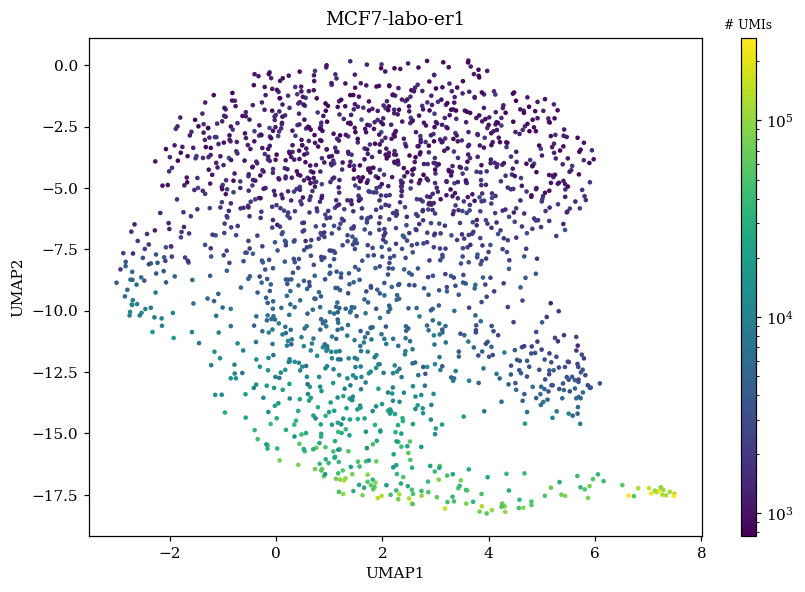

In [594]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["total_UMIs"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "# UMIs", title = new_sample_name)

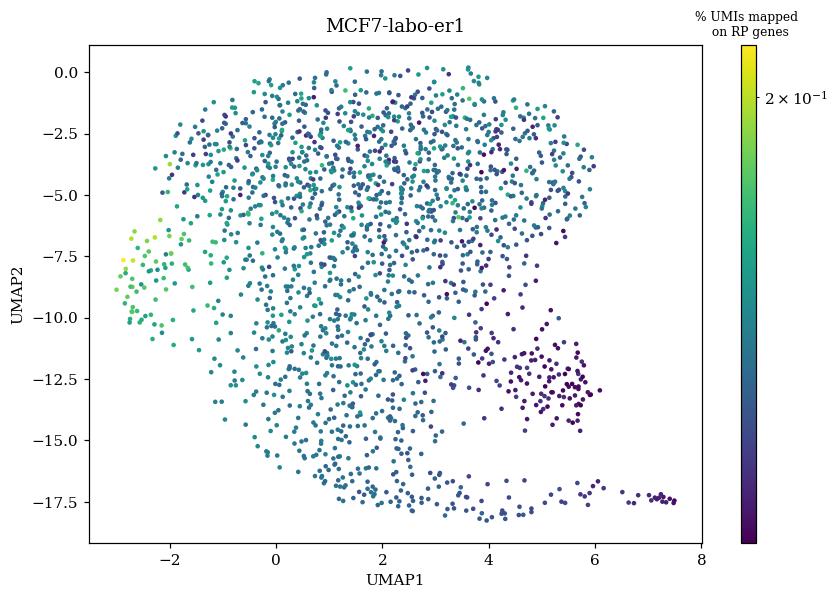

In [484]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["rp_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on RP genes", title = new_sample_name)

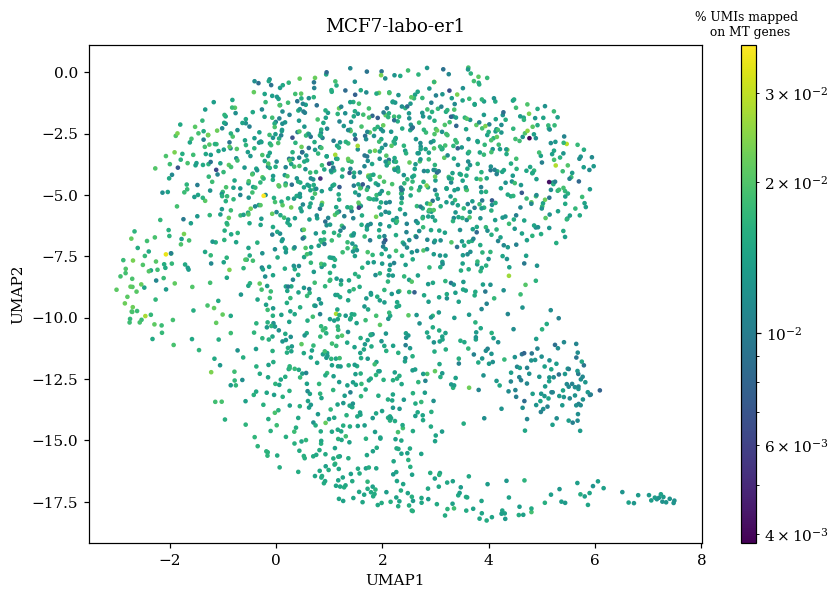

In [485]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["mt_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on MT genes", title = new_sample_name)

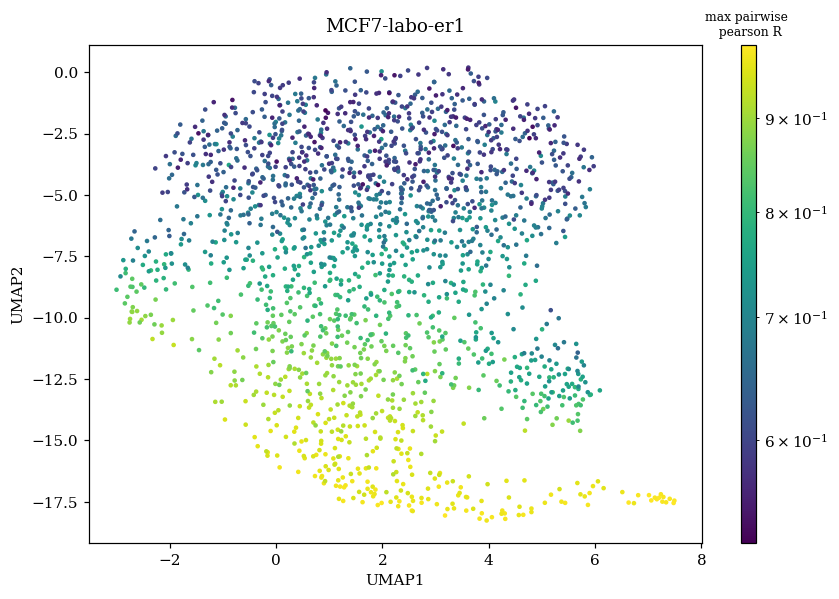

In [486]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

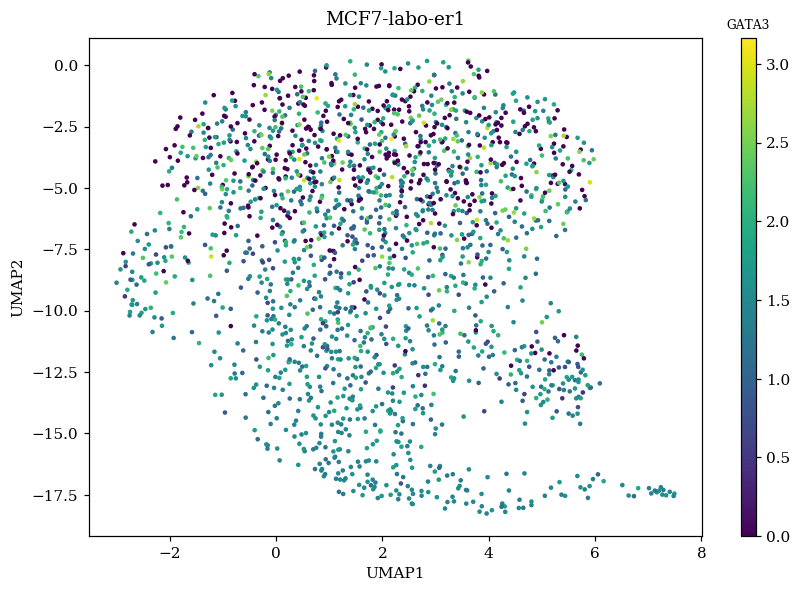

In [597]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.X.toarray()[:, sc.var["external_gene_name"] == "GAPDH"].ravel(), \
    s = 4, xlabel="UMAP1", ylabel="UMAP2", color_title = "GATA3", title = new_sample_name)

##### QC metrics distibutions

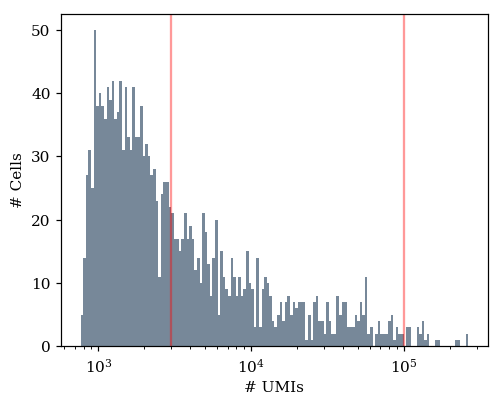

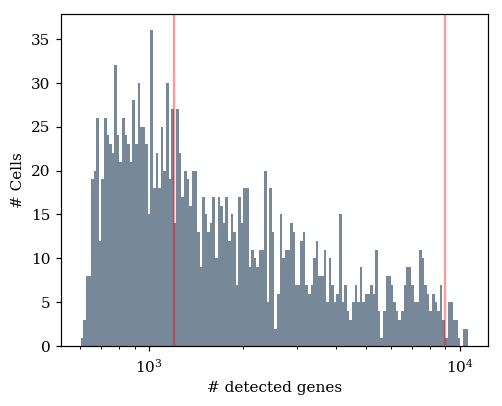

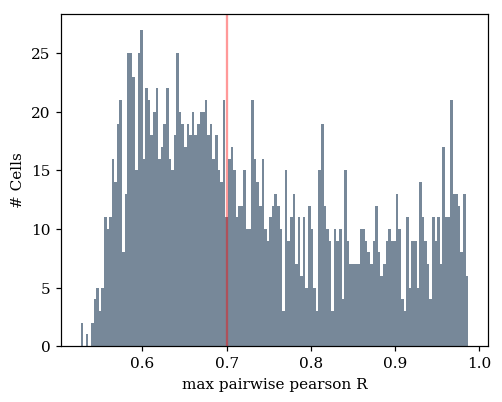

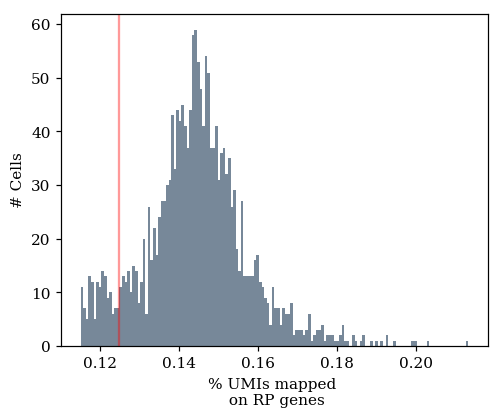

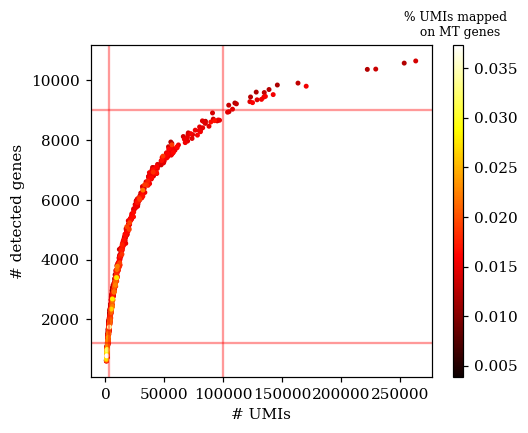

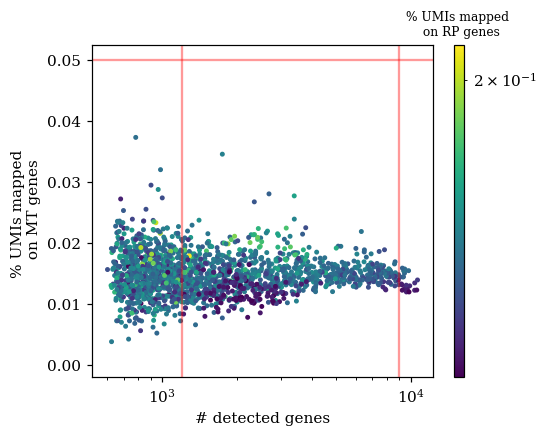

In [487]:
rnaseq.pp.plot_qc(sc, n_counts_max=100000, n_counts_min = 2000, n_genes_max=9000, n_genes_min = 1000, mt_max = 0.05, max_corr_thr = 0.72, rp_min = 0.13, n_bins = 150)

#### Test some thresholds

##### Umap

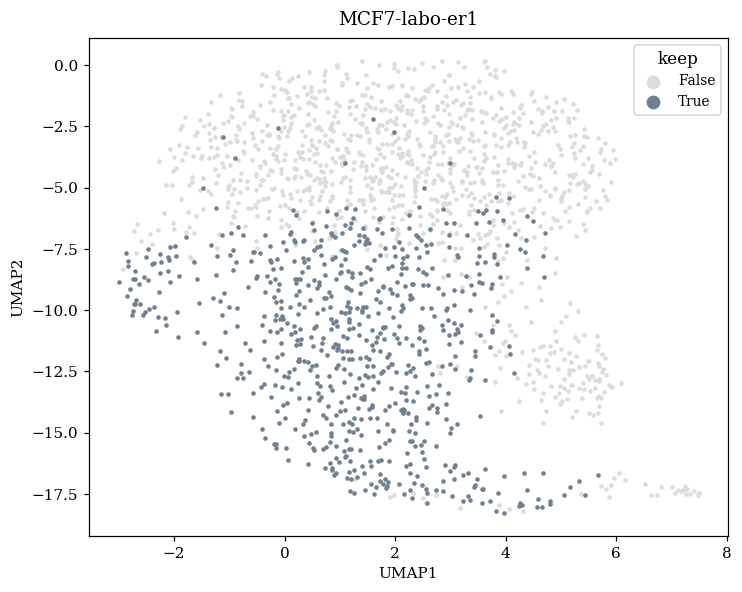

In [506]:
rnaseq.pp.filter_cells(sc, n_counts_max=100000, n_counts_min = 2000, n_genes_max=9000, n_genes_min = 1000, mt_max = 0.05, max_corr_thr = 0.72, rp_min = 0.13, inplace = False)

plt.subplots(figsize = (7.5,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["keep"], \
    s = 4, norm = LogNorm(), xlabel="UMAP1", ylabel="UMAP2", color_title = "keep", \
    title = new_sample_name, palette = {"True" : "slategray", "False" : "gainsboro"})

##### DEA

In [462]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="keep", method = "wilcoxon", groups=["True"], reference="False", n_genes=2000, rankby_abs=True)

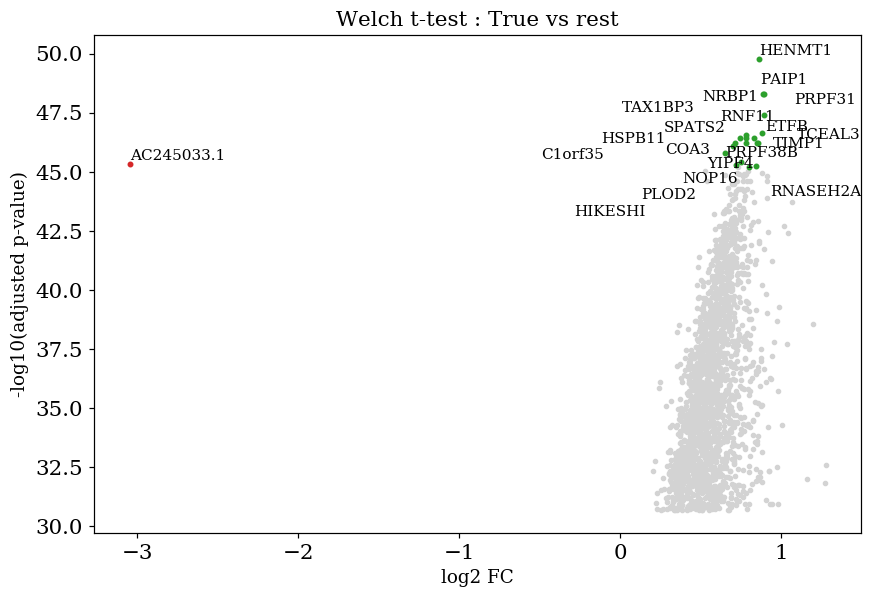

In [463]:
rnaseq.dea.volcano_plot(sc, group = "True")

#### Filtering cells

In [559]:
rnaseq.pp.filter_cells(sc, n_counts_max=100000, n_counts_min = 2000, n_genes_max=9000, n_genes_min = 1000, mt_max = 0.05, max_corr_thr = 0.72, rp_min = 0.13, inplace = True)

#### Number of cells after filtering

In [508]:
sc.X.shape

(723, 20305)

### 3rd filtering

#### QC before filtering

##### Umap

Normalization by total UMIs...
Log2 + 1 tranformation...


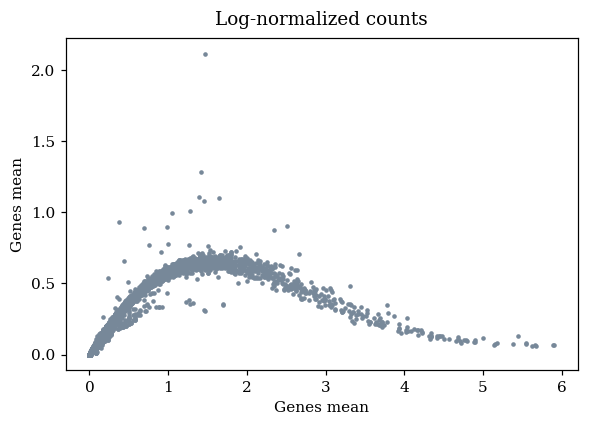

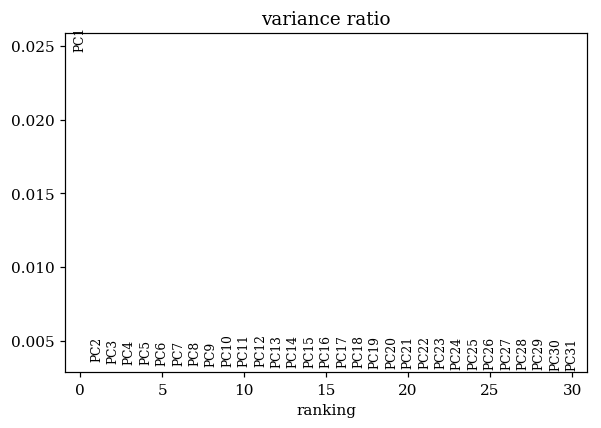

In [560]:
rnaseq.pp.log_norm(sc, plot=True, inplace=True, ow = True)
scanpy.pp.pca(sc, use_highly_variable=False)
scanpy.pl.pca_variance_ratio(sc)

In [561]:
scanpy.pp.neighbors(sc, n_pcs = 30, n_neighbors = 30)
scanpy.tl.umap(sc, spread = 2)

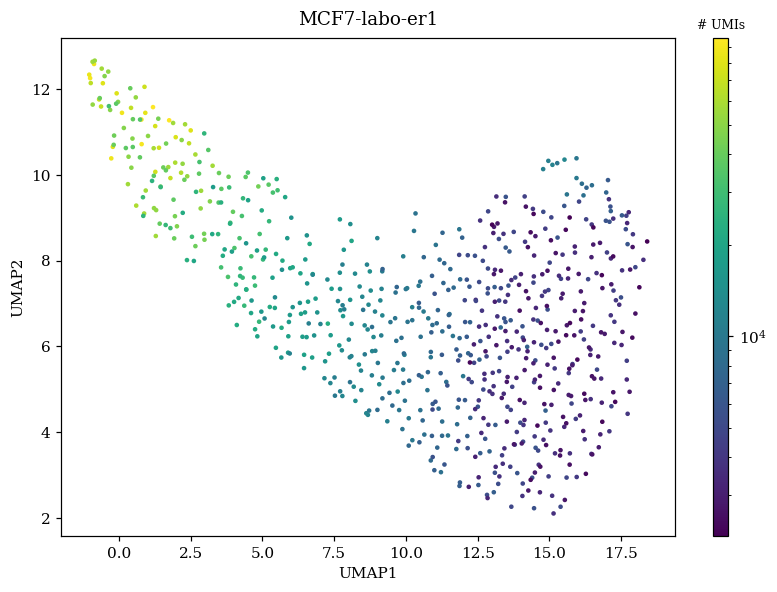

In [562]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["total_UMIs"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "# UMIs", title = new_sample_name)

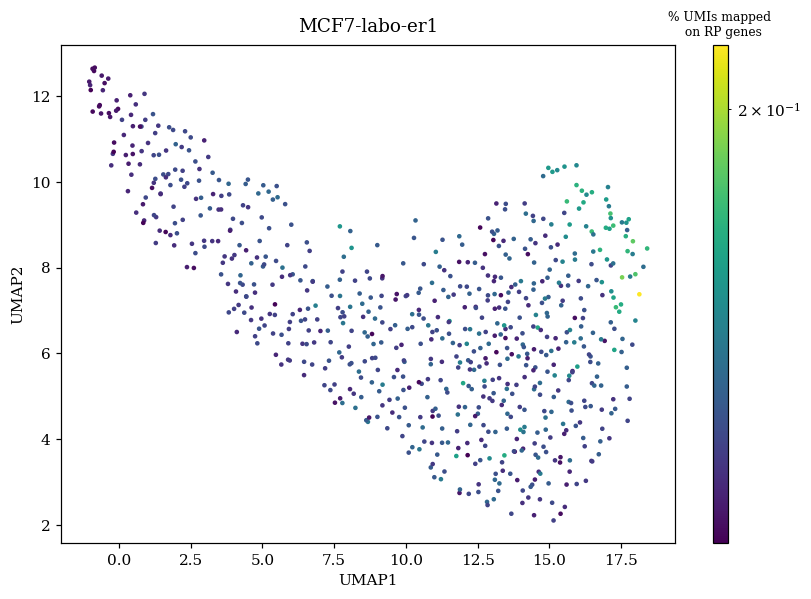

In [533]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["rp_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on RP genes", title = new_sample_name)

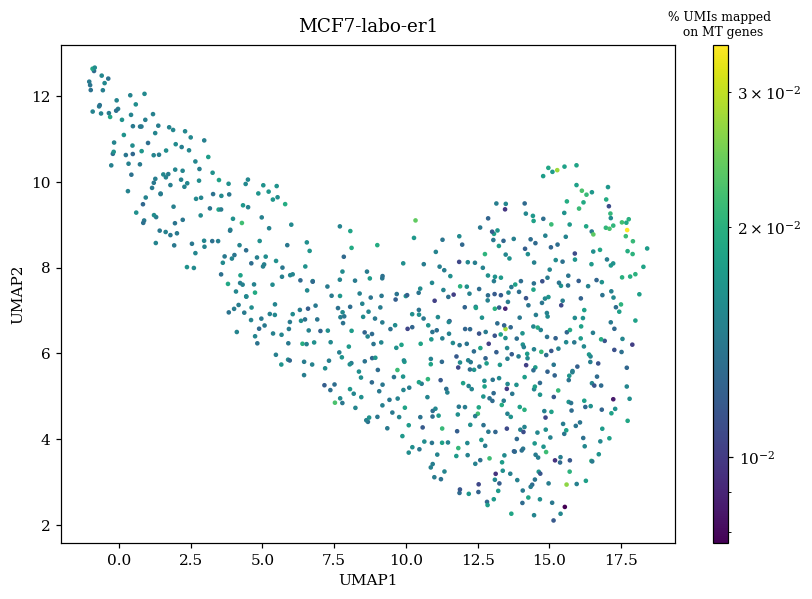

In [534]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["mt_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on MT genes", title = new_sample_name)

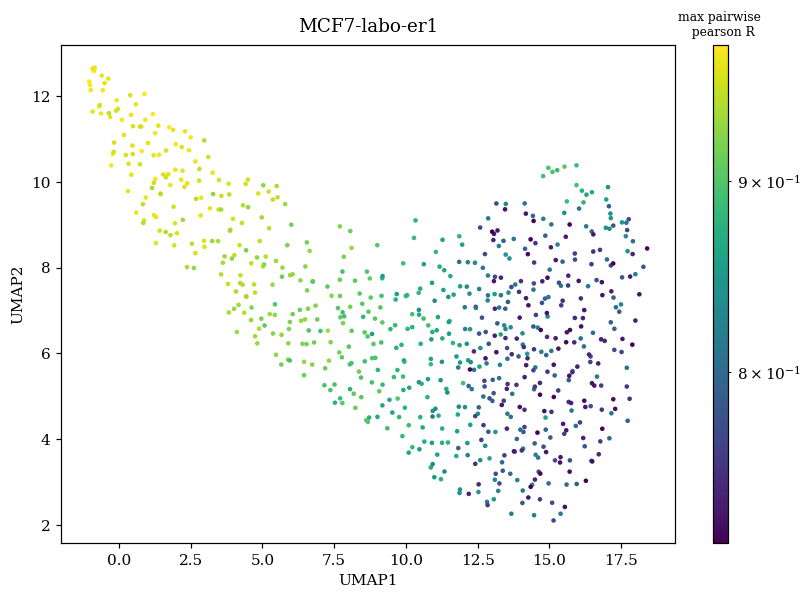

In [535]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

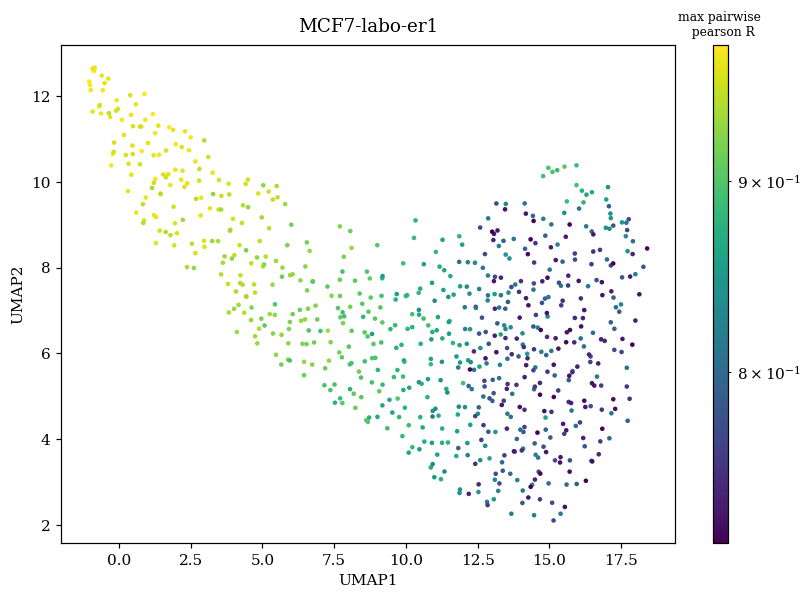

In [535]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

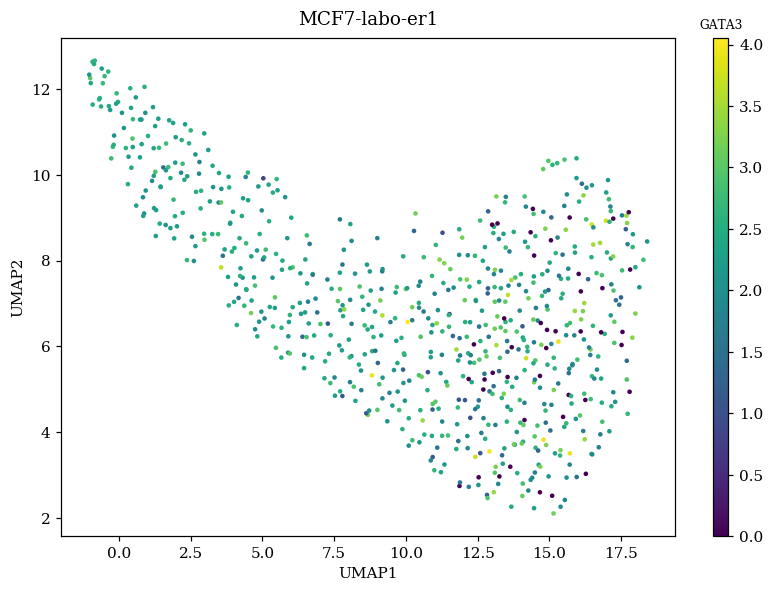

In [589]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.X.toarray()[:, sc.var["external_gene_name"] == "GATA3"].ravel(), \
    s = 4, xlabel="UMAP1", ylabel="UMAP2", color_title = "GATA3", title = new_sample_name)

##### QC metrics distibutions

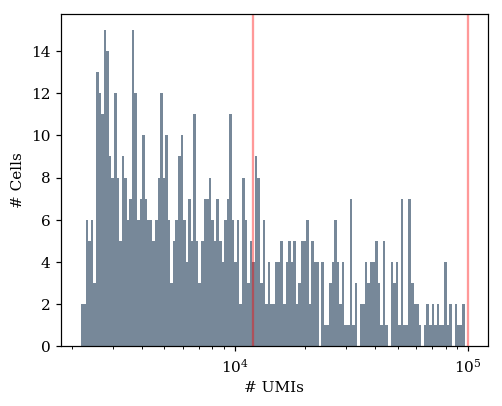

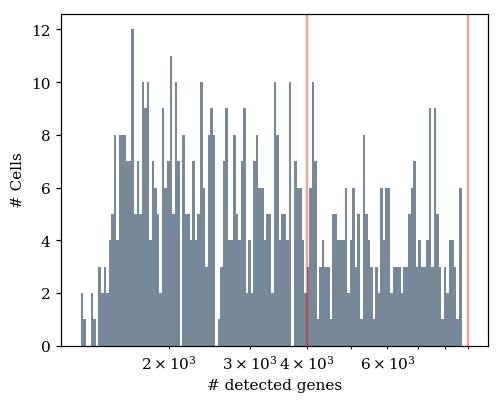

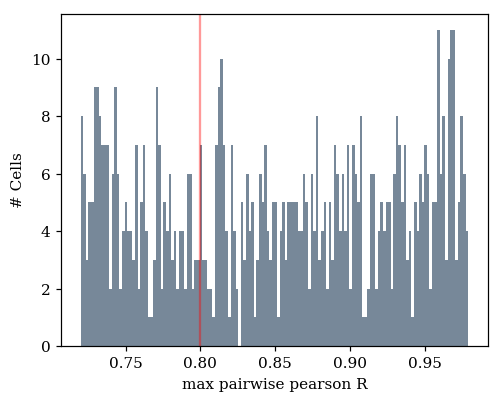

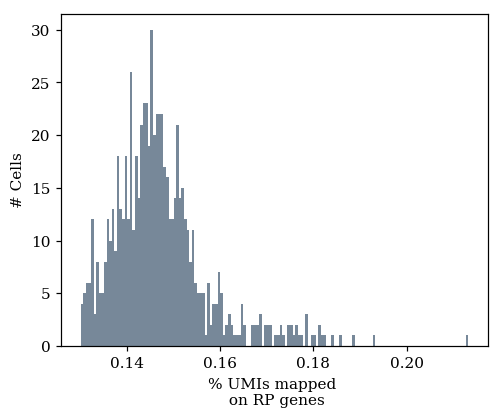

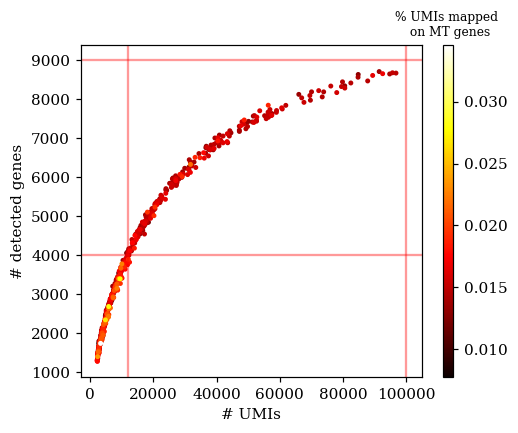

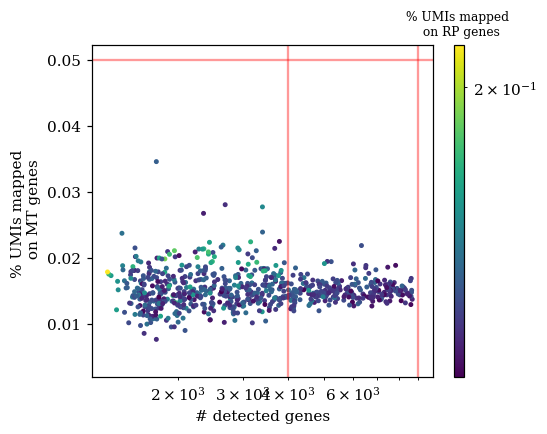

In [582]:
rnaseq.pp.plot_qc(sc, n_counts_max=100000, n_counts_min = 12000, n_genes_max=9000, n_genes_min = 4000, mt_max = 0.05, max_corr_thr = 0.8, n_bins = 150)

#### Test some thresholds

##### Umap

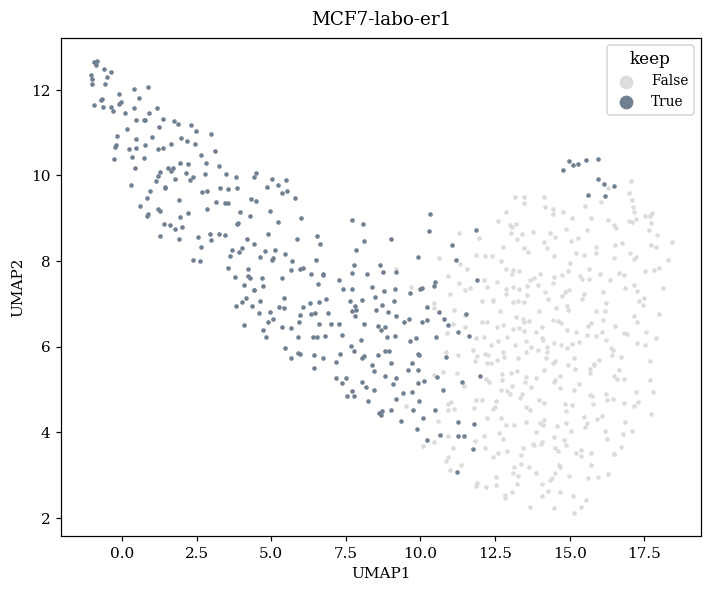

In [580]:
rnaseq.pp.filter_cells(sc, n_counts_max=100000, n_counts_min = 8000, n_genes_max=9000, n_genes_min = 3000, mt_max = 0.05, max_corr_thr = 0.8, inplace = False)

plt.subplots(figsize = (7.5,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["keep"], \
    s = 4, norm = LogNorm(), xlabel="UMAP1", ylabel="UMAP2", color_title = "keep", \
    title = new_sample_name, palette = {"True" : "slategray", "False" : "gainsboro"})

##### DEA

In [577]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="keep", method = "wilcoxon", groups=["True"], reference="False", n_genes=2000, rankby_abs=True)

... storing 'samples' as categorical
... storing 'project_id' as categorical
... storing 'conditions' as categorical
... storing 'cell_lines' as categorical
... storing 'source' as categorical
... storing 'keep' as categorical
... storing 'chromosome_name' as categorical
... storing 'external_gene_name' as categorical


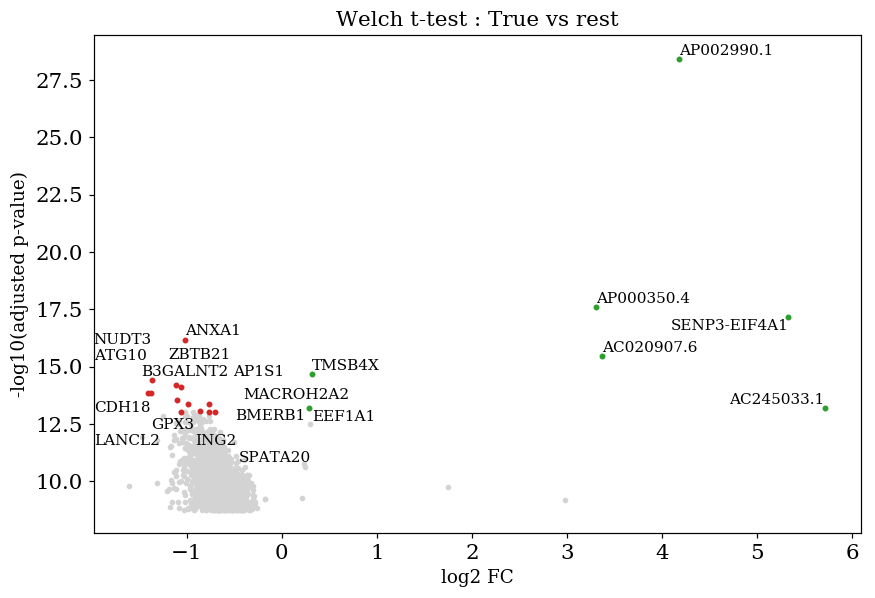

In [578]:
rnaseq.dea.volcano_plot(sc, group = "True")

#### Filtering cells

In [550]:
rnaseq.pp.filter_cells(sc, n_counts_max=100000, n_counts_min = 5000, n_genes_max=9000, n_genes_min = 2500, mt_max = 0.05, max_corr_thr = 0.77, inplace = True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


#### Number of cells after filtering

In [551]:
sc.X.shape

(434, 20305)

### Final dataset

##### Umap

Normalization by total UMIs...
Log2 + 1 tranformation...


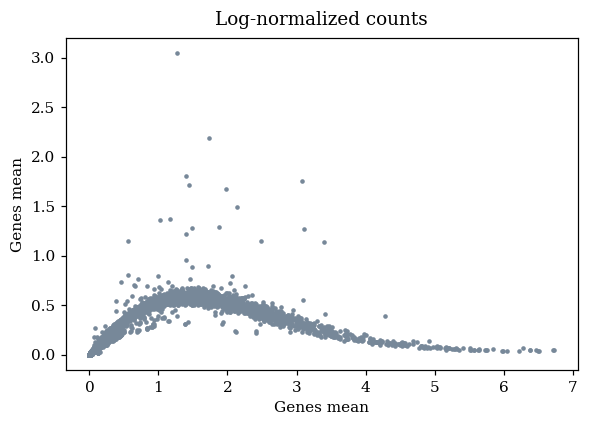

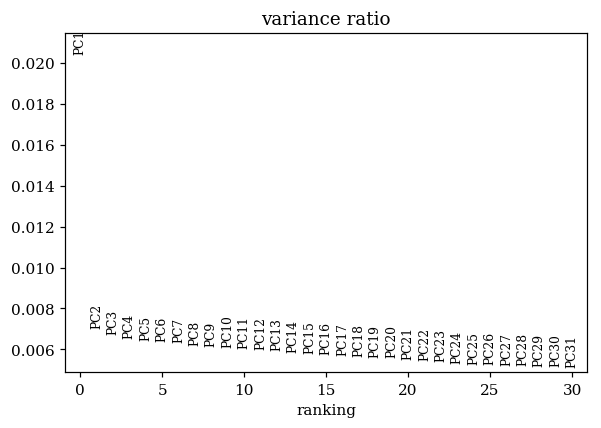

In [552]:
rnaseq.pp.log_norm(sc, plot=True, inplace=True, ow = True)
scanpy.pp.highly_variable_genes(sc)
scanpy.pp.pca(sc, use_highly_variable=True)
scanpy.pl.pca_variance_ratio(sc)

In [553]:
scanpy.pp.neighbors(sc, n_pcs = 15, n_neighbors = 30)
scanpy.tl.umap(sc, spread = 2)

In [462]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="keep", method = "wilcoxon", groups=["True"], reference="False", n_genes=2000, rankby_abs=True)

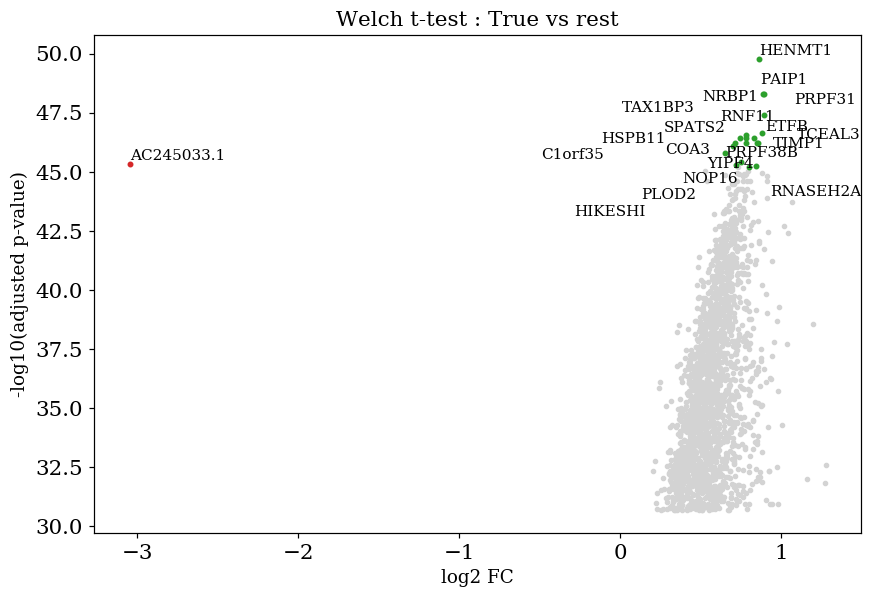

In [463]:
rnaseq.dea.volcano_plot(sc, group = "True")

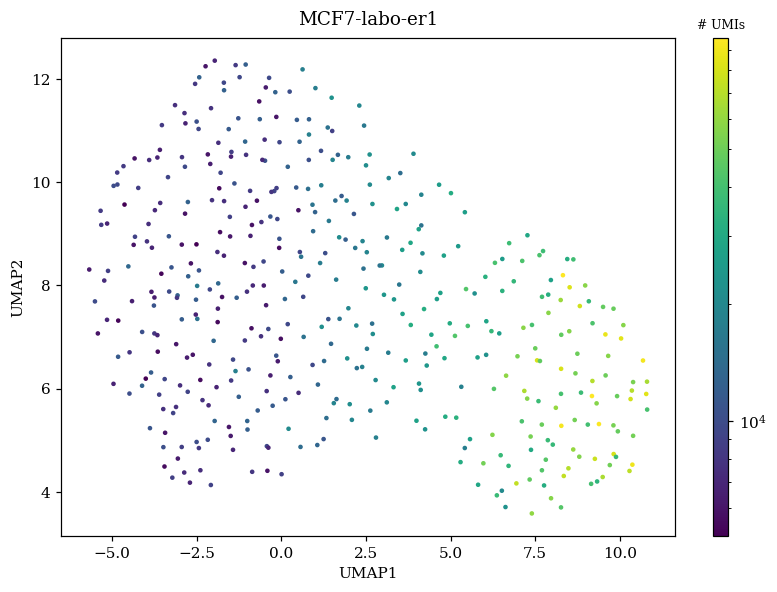

In [555]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["total_UMIs"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "# UMIs", title = new_sample_name)

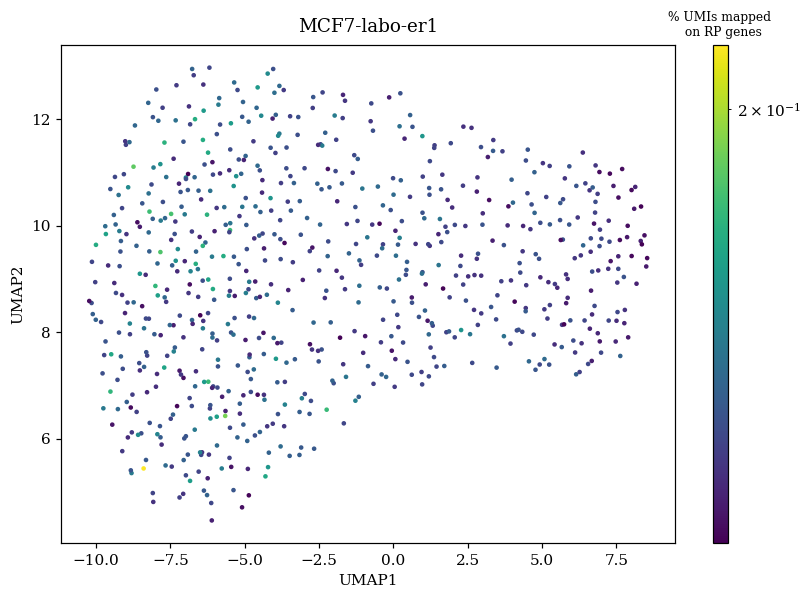

In [524]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["rp_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on RP genes", title = new_sample_name)

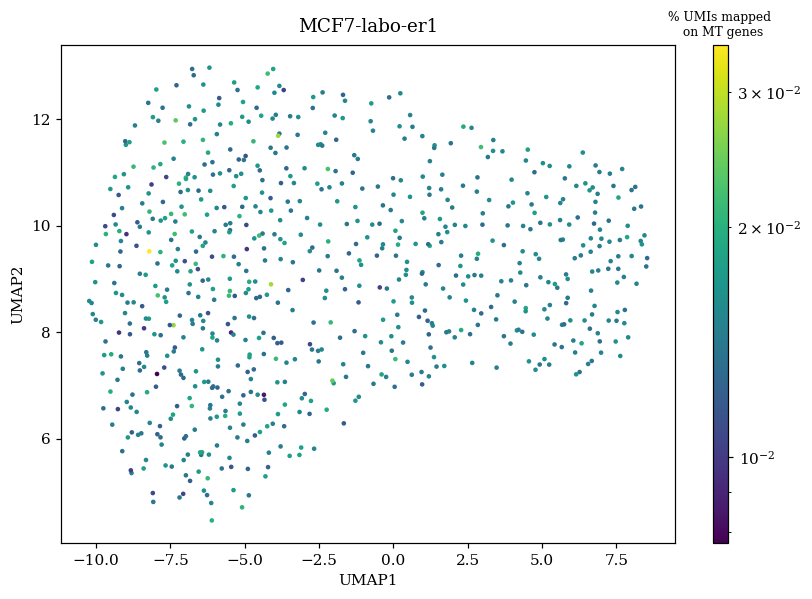

In [525]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["mt_frac"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "% UMIs mapped \n on MT genes", title = new_sample_name)

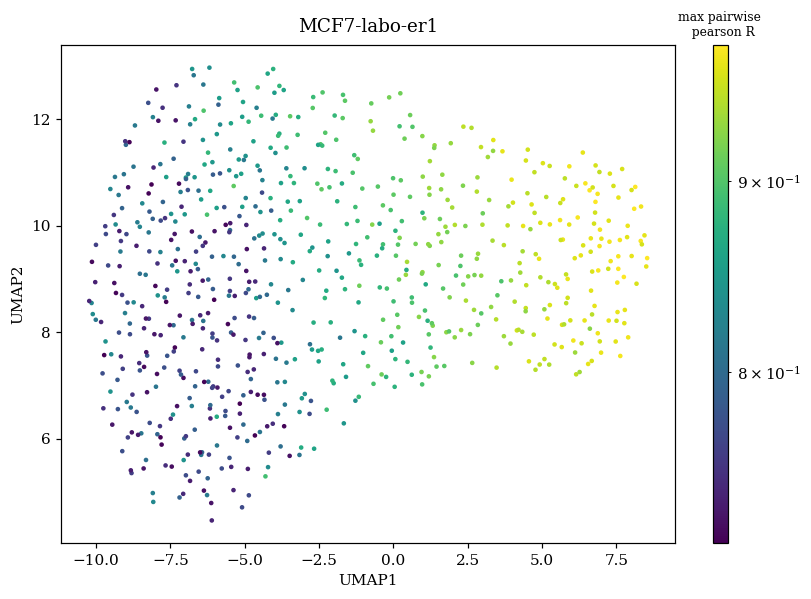

In [526]:
plt.subplots(figsize = (9,6))
rnaseq.plotting.scatter(sc.obsm["X_umap"][:,0], sc.obsm["X_umap"][:,1], color = sc.obs["max_corr"], \
    s = 4, norm = LogNorm(), palette = "viridis", xlabel="UMAP1", ylabel="UMAP2", color_title = "max pairwise \n pearson R", title = new_sample_name)

##### QC metrics distibutions

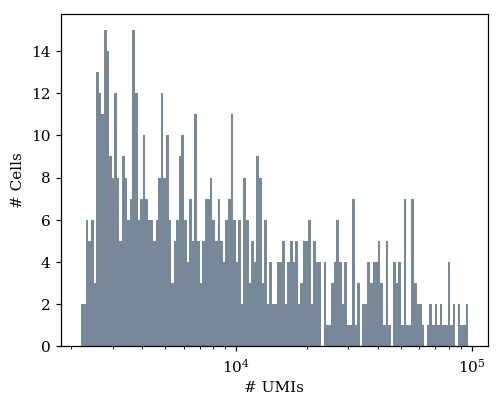

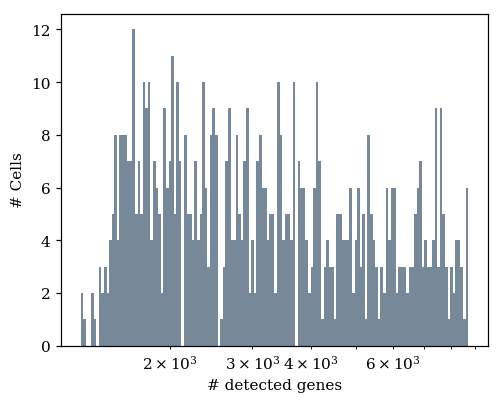

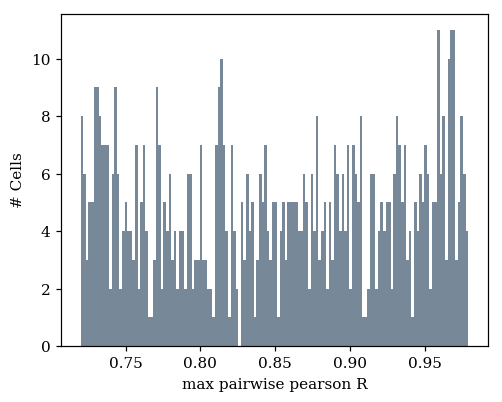

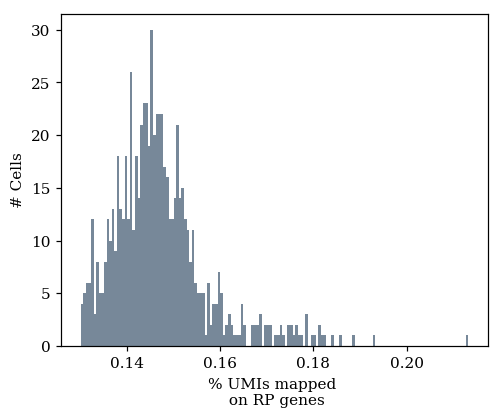

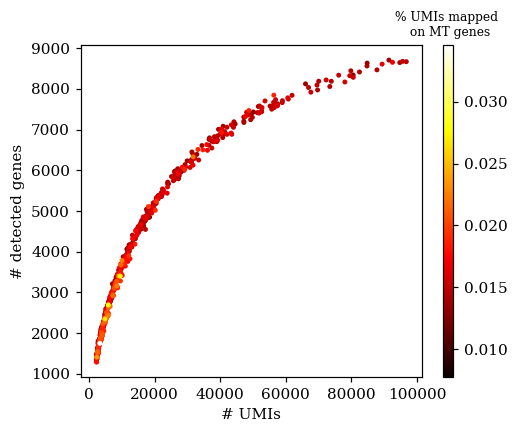

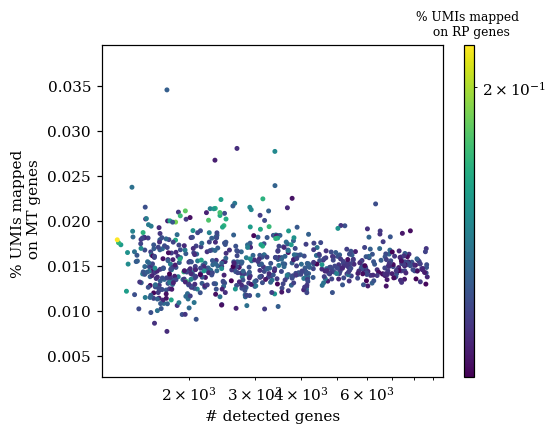

In [511]:
rnaseq.pp.plot_qc(sc)

### Write filtered anndata

In [576]:
del sc.layers["log_norm"]
rnaseq.setup.load_layer(sc, "raw")
sc._inplace_subset_obs(sc.obs["keep"])
rnaseq.readwrite.write_filtered(sc, "/home/arion/davidm/Data/datasets/processed/Projects/scBC-Analysis/filtered_data")

... storing 'samples' as categorical
... storing 'project_id' as categorical
... storing 'conditions' as categorical
... storing 'cell_lines' as categorical
... storing 'source' as categorical
... storing 'chromosome_name' as categorical
... storing 'external_gene_name' as categorical
